Пример сравнения моделей

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from typing import Optional, Union, Dict, List
from statsmodels.stats.weightstats import ztest

class ModelComparator:
    """
    Класс для сравнения:
    - Гиперпараметров моделей с эталонными значениями
    - Гиперпараметров разных версий моделей
    - Метрик качества (WAPE, MAPE, и другие)
    - Визуализации результатов статистических тестов
    """

    def __init__(self):
        self.results = pd.DataFrame(columns=['Test Type', 'Parameter/Metric', 'Statistic', 'p-value', 'Decision'])

    def _run_statistical_test(self, data1: list | np.ndarray, data2: list | np.ndarray,
                              test_type: str, alpha: float) -> tuple[float, float, str]:
        """
        Внутренний метод для выполнения выбранного статистического теста.

        :param data1: Первая выборка данных.
        :param data2: Вторая выборка данных.
        :param test_type: Тип теста ('t-test' или 'z-test').
        :param alpha: Уровень значимости.
        :return: Кортеж из (статистика, p-значение, решение).
        """
        data1 = np.asarray(data1)
        data2 = np.asarray(data2)

        if len(data1) < 2 or len(data2) < 2:
            raise ValueError("Для статистического теста требуется не менее двух значений в каждой выборке.")
        if not np.issubdtype(data1.dtype, np.number) or not np.issubdtype(data2.dtype, np.number):
            raise TypeError("Данные для статистического теста должны быть числовыми.")

        statistic, p_value = np.nan, np.nan

        if test_type == 't-test':
            statistic, p_value = ttest_ind(data1, data2, equal_var=False)
        elif test_type == 'z-test':
            statistic, p_value = ztest(x1=data1, x2=data2, value=0, alternative='two-sided')
        else:
            raise ValueError("Неподдерживаемый тип теста. Используйте 't-test' или 'z-test'.")

        decision = "Разные" if p_value < alpha else "Одинаковые"
        return statistic, p_value, decision

    def compare_with_baseline(self, current_params: Dict[str, list | np.ndarray],
                              baseline_params: Dict[str, list | np.ndarray],
                              alpha: float = 0.05, test_type: str = 't-test'):
        """
        Сравнение параметров текущей модели с эталонными значениями.

        :param current_params: Текущие параметры модели {'param1': [value1_run1, value1_run2], ...}
        :param baseline_params: Эталонные параметры {'param1': [value1_baseline1, value1_baseline2], ...}
        :param alpha: Уровень значимости.
        :param test_type: Тип статистического теста ('t-test' или 'z-test').
        """
        for param, baseline_vals in baseline_params.items():
            if param in current_params:
                current_vals = current_params[param]
                try:
                    statistic, p_value, decision = self._run_statistical_test(current_vals, baseline_vals, test_type, alpha)
                    self.results.loc[len(self.results)] = [test_type, f"Эталонный {param}", statistic, p_value, decision]
                except (ValueError, TypeError) as e:
                    print(f"Ошибка при сравнении параметра {param} с эталоном: {e}")
                    self.results.loc[len(self.results)] = [test_type, f"Эталонный {param}", np.nan, np.nan, f"Ошибка: {e}"]
            else:
                print(f"Параметр '{param}' отсутствует в текущих параметрах модели. Пропуск сравнения.")

    def compare_versions(self, version1_params: Dict[str, list | np.ndarray],
                         version2_params: Dict[str, list | np.ndarray],
                         alpha: float = 0.05, test_type: str = 't-test'):
        """
        Сравнение параметров двух версий модели.

        :param version1_params: Параметры первой версии {'param1': [value1_v1_run1, ...], ...}
        :param version2_params: Параметры второй версии {'param1': [value1_v2_run1, ...], ...}
        :param alpha: Уровень значимости.
        :param test_type: Тип статистического теста ('t-test' или 'z-test').
        """
        common_params = set(version1_params.keys()) & set(version2_params.keys())
        for param in common_params:
            v1_vals = version1_params[param]
            v2_vals = version2_params[param]
            try:
                statistic, p_value, decision = self._run_statistical_test(v1_vals, v2_vals, test_type, alpha)
                self.results.loc[len(self.results)] = [test_type, f"Версии {param}", statistic, p_value, decision]
            except (ValueError, TypeError) as e:
                print(f"Ошибка при сравнении параметра '{param}' между версиями: {e}")
                self.results.loc[len(self.results)] = [test_type, f"Версии {param}", np.nan, np.nan, f"Ошибка: {e}"]
        
        if not common_params:
            print("Нет общих параметров для сравнения между версиями.")

    def compare_metrics(self, metrics_v1: Dict[str, list | np.ndarray],
                        metrics_v2: Dict[str, list | np.ndarray],
                        alpha: float = 0.05, test_type: str = 't-test'):
        """
        Сравнение метрик качества (WAPE, MAPE и др.) между двумя версиями.

        :param metrics_v1: Метрики первой версии {'WAPE': [val1, val2], 'MAPE': [val1, val2]}
        :param metrics_v2: Метрики второй версии {'WAPE': [val1, val2], 'MAPE': [val1, val2]}
        :param alpha: Уровень значимости.
        :param test_type: Тип статистического теста ('t-test' или 'z-test').
        """
        common_metrics = set(metrics_v1.keys()) & set(metrics_v2.keys())
        for metric in common_metrics:
            v1_vals = metrics_v1[metric]
            v2_vals = metrics_v2[metric]
            try:
                statistic, p_value, decision = self._run_statistical_test(v1_vals, v2_vals, test_type, alpha)
                self.results.loc[len(self.results)] = [test_type, f"Метрика {metric}", statistic, p_value, decision]
            except (ValueError, TypeError) as e:
                print(f"Ошибка при сравнении метрики '{metric}': {e}")
                self.results.loc[len(self.results)] = [test_type, f"Метрика {metric}", np.nan, np.nan, f"Ошибка: {e}"]
        
        if not common_metrics:
            print("Нет общих метрик для сравнения.")

    def visualize_comparison(self, save_path: Optional[str] = None) -> None:
        """
        Визуализация результатов сравнения: p-значения и статистики тестов.

        :param save_path: Путь для сохранения графиков (если None - показ в окне).
        """
        if self.results.empty:
            print("Нет данных для визуализации. Сначала выполните сравнения.")
            return

        num_tests = len(self.results)
        if num_tests == 0:
            print("Нет результатов для построения графиков.")
            return

        fig, axes = plt.subplots(1, 2, figsize=(16, max(6, num_tests * 0.5)))

        axes[0].barh(self.results['Parameter/Metric'], self.results['p-value'],
                     color=['salmon' if p < 0.05 else 'forestgreen' for p in self.results['p-value']])
        axes[0].axvline(0.05, color='black', linestyle='--', label='Уровень значимости (0.05)')
        axes[0].set_title('Статистическая значимость (p-значения)')
        axes[0].set_xlabel('p-значение')
        axes[0].set_ylabel('Параметр /\n Метрика', rotation="horizontal")
        axes[0].legend()
        axes[0].grid(axis='x', linestyle='--')
        axes[0].invert_yaxis()

        bars = axes[1].barh(self.results['Parameter/Metric'], self.results['Statistic'],
                            color=['skyblue' if s >= 0 else 'salmon' for s in self.results['Statistic']])
        axes[1].set_title('Статистики тестов')
        axes[1].set_xlabel('Значение статистики')
        axes[1].set_ylabel('Параметр /\n Метрика', rotation="horizontal")
        axes[1].grid(axis='x', linestyle='--')
        axes[1].invert_yaxis()

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
            plt.close()
        else:
            plt.show()

    def get_results(self) -> pd.DataFrame:
        """Возвращает DataFrame с результатами сравнений."""
        return self.results

Сравнение текущей модели с эталонными параметрами (t-тест):
  Test Type         Parameter/Metric  Statistic   p-value    Decision
0    t-test  Эталонный learning_rate   1.553251  0.125807  Одинаковые
1    t-test     Эталонный batch_size  -1.682013  0.097952  Одинаковые
2    t-test     Эталонный num_layers   0.876155  0.384570  Одинаковые


Сравнение версий модели (z-тест для больших выборок):
  Test Type         Parameter/Metric  Statistic   p-value    Decision
0    t-test  Эталонный learning_rate   1.553251  0.125807  Одинаковые
1    t-test     Эталонный batch_size  -1.682013  0.097952  Одинаковые
2    t-test     Эталонный num_layers   0.876155  0.384570  Одинаковые
3    z-test      Версии n_estimators  -2.062193  0.039189      Разные
4    z-test         Версии max_depth  -0.036328  0.971021  Одинаковые
5    z-test     Версии learning_rate   2.590243  0.009591      Разные


Сравнение метрик моделей (t-тест):
  Test Type         Parameter/Metric  Statistic   p-value    Decision
0    t-

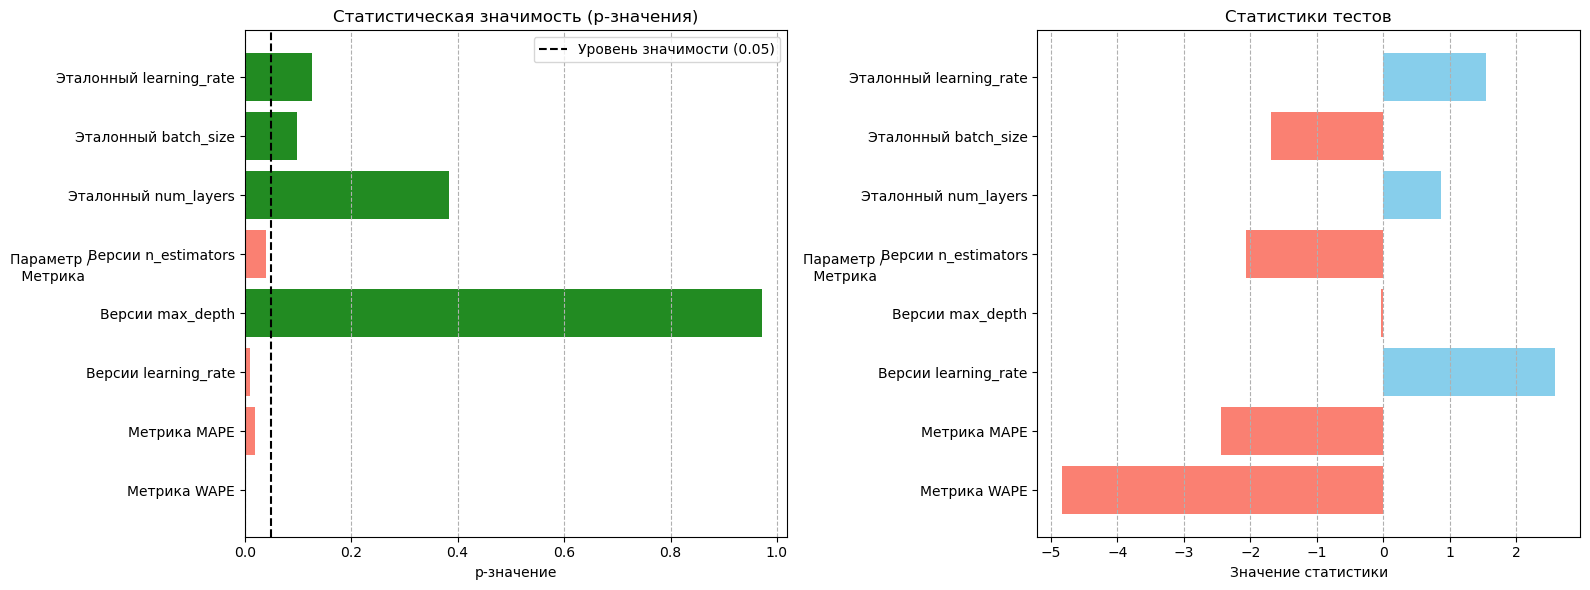

In [4]:
comparator = ModelComparator()

current_model_params = {
    'learning_rate': np.random.normal(0.012, 0.001, 30),
    'batch_size': np.random.randint(16, 64, 30),
    'num_layers': np.random.randint(2, 5, 30)
}

baseline_params = {
    'learning_rate': np.random.normal(0.012, 0.001, 30),
    'batch_size': np.random.randint(16, 64, 30),
    'num_layers': np.random.randint(2, 5, 30)
}

version1_params = {
    'n_estimators': np.random.randint(100, 200, 50),
    'max_depth': np.random.randint(5, 15, 50),
    'learning_rate': np.random.normal(0.05, 0.005, 50)
}

version2_params = {
    'n_estimators': np.random.randint(100, 200, 50),
    'max_depth': np.random.randint(5, 15, 50),
    'learning_rate': np.random.normal(0.048, 0.005, 50)
}

metrics_model_A = {
    'WAPE': np.random.normal(0.10, 0.001, 40),
    'MAPE': np.random.normal(0.15, 0.002, 40)
}

metrics_model_B = {
    'WAPE': np.random.normal(0.11, 0.01, 40),
    'MAPE': np.random.normal(0.16, 0.02, 40)
}

print("Сравнение текущей модели с эталонными параметрами (t-тест):")
comparator.compare_with_baseline(current_model_params, baseline_params, test_type='t-test')
print(comparator.get_results())
print("\n" + "="*50 + "\n")

print("Сравнение версий модели (z-тест для больших выборок):")
comparator.compare_versions(version1_params, version2_params, test_type='z-test')
print(comparator.get_results())
print("\n" + "="*50 + "\n")

print("Сравнение метрик моделей (t-тест):")
comparator.compare_metrics(metrics_model_A, metrics_model_B, test_type='t-test')
print(comparator.get_results())
print("\n" + "="*50 + "\n")

comparator.visualize_comparison()